In [7]:
!python -V

Python 3.12.3


In [228]:
#pip install mlflow

import mlflow

# Set the MLflow tracking URI to the local server
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1734669597337, experiment_id='1', last_update_time=1734669597337, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [104]:
import pandas as pd
import numpy as np

In [5]:
import pickle

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [70]:
# df_train = read_dataframe('./data/green_tripdata_2021-01.csv')
# df_val = read_dataframe('./data/green_tripdata_2021-02.csv')

df_train = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df_val = pd.read_parquet('./data/green_tripdata_2021-02.parquet')

In [88]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [112]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mse = mean_squared_error(y_train, y_pred) #, squared=False)
mse

96.80198150112749

In [110]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
rmse

9.838799799829626

C:\Users\obalo\AppData\Local\Temp\ipykernel_55040\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\obalo\AppData\Local\Temp\ipykernel_55040\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


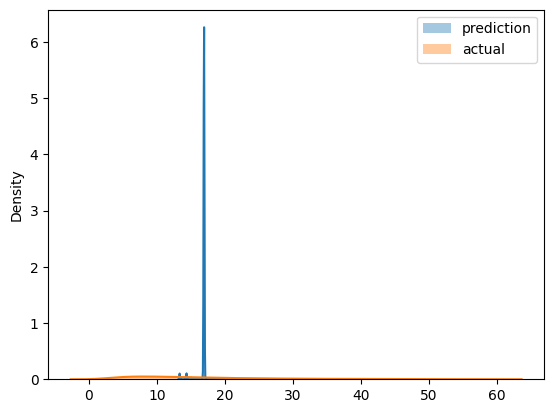

In [257]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [118]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [128]:
# df_train = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
# df_val = pd.read_parquet('./data/green_tripdata_2021-02.parquet')

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [132]:
len(df_train), len(df_val)

(73908, 61921)

In [140]:
# df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
# df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

df_train['PU_DO'] = df_train['PULocationID'].astype(str) + '_' + df_train['DOLocationID'].astype(str)
df_val['PU_DO'] = df_val['PULocationID'].astype(str) + '_' + df_val['DOLocationID'].astype(str)

print(df_train.head())  # Check the first few rows to confirm 'PU_DO' exists
print(df_val.head())    # Check the first few rows to confirm 'PU_DO' exists



   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3         2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
7         2  2021-01-01 00:26:31   2021-01-01 00:28:50                  N   

   RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0         1.0           43          151              1.0           1.01   
1         1.0          166          239              1.0           2.53   
2         1.0           41           42              1.0           1.12   
3         1.0          168           75              1.0           1.99   
7         1.0           75           75              6.0           0.45   

   fare_amount  ...  tip_amount  tolls_amount  ehail_fee  \
0          5.5  ...       

In [206]:
# Check if 'PU_DO' is in df_train and df_val
if 'PU_DO' not in df_train.columns:
    print("PU_DO is missing in training data.")
if 'PU_DO' not in df_val.columns:
    print("PU_DO is missing in validation data.")


In [208]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [150]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [210]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred)   #, squared=False)
mse

60.197661628646756

In [161]:
# rmse = np.sqrt(mean_squared_error(y_train, y_pred))
# rmse

In [165]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)

In [298]:
# get RMSE and record on mlflow
rmse = round(mean_squared_error(y_val, y_pred),2)
print("RMSE for training data:", rmse)
mlflow.log_metric("rmse", rmse)

RMSE for training data: 147.46


In [314]:
# start logging with mlflow
with mlflow.start_run():
    # set tag for mlflow
    mlflow.set_tag("developer", "Bengsoon")

    # set data path param
    mlflow.log_param("train-data-path", "'./data/green_tripdata_2021-01.parquet'")
    mlflow.log_param("valid-data-path", "'./data/green_tripdata_2021-02.parquet'")

    # set hyper parameter for Lasso
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha = alpha)
    
    # train the model
    lr.fit(X_train, y_train)

    # get the y_pred from X_train
    y_pred = lr.predict(X_val)

    # get RMSE and record on mlflow
    rmse = round(mean_squared_error(y_val, y_pred),2)
    print("RMSE for training data:", rmse)
    mlflow.log_metric("rmse", rmse)

#mlflow.end_run()

Exception: Run with UUID d86c1289a2e6490aaf3bc5ab3aeaf84f is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [296]:
#mlflow.end_run()

🏃 View run angry-vole-549 at: http://127.0.0.1:5000/#/experiments/1/runs/4498fe9e644e43d89df155ec4a28b041
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [302]:
import xgboost as xgb

In [304]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [306]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [308]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [259]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: Run with UUID 2aeb63c6686d4560ad3e4b082afd53fb is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True



  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]


Exception: Run with UUID 2aeb63c6686d4560ad3e4b082afd53fb is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [261]:
#mlflow.end_run()

🏃 View run sneaky-rat-22 at: http://127.0.0.1:5000/#/experiments/1/runs/2aeb63c6686d4560ad3e4b082afd53fb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [226]:
mlflow.xgboost.autolog(disable=True)

In [310]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

Exception: Run with UUID d86c1289a2e6490aaf3bc5ab3aeaf84f is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [312]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

2024/12/20 00:24:03 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


Exception: Run with UUID d86c1289a2e6490aaf3bc5ab3aeaf84f is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True